In [1]:
import meep as mp
from meep import mpb
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

In [2]:
num_bands = 31
gaas = mp.Medium(epsilon=12.96)
k_points = [mp.Vector3(0., 0.5),]

geometry_lattice = mp.Lattice(size=mp.Vector3(5, 5),
                              basis1=mp.Vector3(math.sqrt(3)/2, 0.5),
                              basis2=mp.Vector3(math.sqrt(3)/2, -0.5))

geometry = [mp.Cylinder(0.25, material=gaas)]
geometry = mp.geometric_objects_lattice_duplicates(geometry_lattice, geometry)
defect = mp.Cylinder(0.6, material=gaas)
geometry.append(defect)

default_material = mp.Medium(epsilon=2.4)

resolution = 32
target_freq = (0.229 + 0.307) / 2

ms = mpb.ModeSolver(num_bands=num_bands,
                    k_points=k_points,
                    geometry=geometry,
                    geometry_lattice=geometry_lattice,
                    resolution=resolution,
                    default_material=default_material,
                    )

efields = []
def get_efields(ms, band):
    efields.append(ms.get_efield(band, bloch_phase=False))

ms.run_tm(mpb.output_at_kpoint(k_points[0]), mpb.fix_efield_phase,
          get_efields)


Initializing eigensolver data
Computing 31 bands with 1e-07 tolerance
1 k-points
  Vector3<0.0, 0.5, 0.0>
elapsed time for initialization: 0.13383746147155762
Outputting epsilon.h5...
elapsed time for k point: 19.498584270477295
total elapsed time for run: 20.181297779083252
done


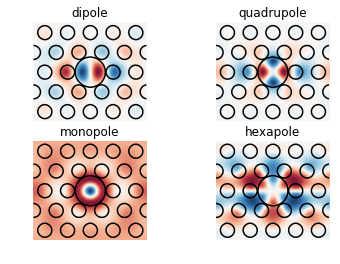

In [14]:
#for i, freq in enumerate(ms.get_freqs()):
#    if 0.229 < freq < 0.307:
#        ms.get_dfield(i, bloch_phase=False)
#        ms.compute_field_energy()
#        # energy = ms.compute_energy_in_objects([defect])
#        energy = ms.compute_energy_in_dielectric(12, 13)
#        print(i, freq, energy)

# Create an MPBData instance to transform the efields
md = mpb.MPBData(rectify=True, resolution=32, periods=1)

converted = []
for i, f in enumerate(efields[25:31]):
    if i in (1, 3):
        continue
    # Get just the z component of the efields
    f = f[..., 0, 2]
    converted.append(md.convert(f))

#smooth_eps = gaussian_filter(converted_eps.T, sigma=1)
eps = ms.get_epsilon()
converted_eps = md.convert(eps)
smooth_eps = gaussian_filter(converted_eps.T, sigma=1)

fig, ax = plt.subplots(2, 2, squeeze=False)
labels = ['dipole', 'quadrupole', 'monopole', 'hexapole']
for i, f in enumerate(converted):
    ax[i//2, i%2].contour(smooth_eps, levels=[3,], cmap='binary_r')
    ax[i//2, i%2].imshow(np.real(f).T, interpolation='spline36', cmap='RdBu', alpha=0.9)
    ax[i//2, i%2].axis('off')
    ax[i//2, i%2].set_title(labels[i])


#result = ms.run_tm(mpb.output_at_kpoint(k_points[0], mpb.fix_efield_phase,
#          mpb.output_efield_z))